In [2]:
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import sys
sys.path.append("..")
from load_data import get_replays
from cluster import supply_total, format_strategy_clustering_data

%matplotlib inline

In [4]:
X, Y = get_replays('../processed_pvp', 0, 'PvP', format_strategy_clustering_data)
data = X[:, 2:]

100%|██████████| 3284/3284 [00:09<00:00, 340.06it/s]


In [5]:
from enum import Enum

class Strategy(Enum):
    UNCATEGORIZED = 0
    CANNON_RUSH = 1
    DISRUPTORS = 2
    MASS_STALKERS = 3
    HEAVY_GROUND = 4
    HEAVY_AIR = 5
    MASS_ADEPTS = 6
    DARK_TEMPLARS = 7
    MASS_ZEALOTS = 8
    PHOENIX = 9

    
def which_strategy(row):
    """
    The input is a row which maps the total amount of the following units:

    Buildings:               Army:
    0: CYBERNETICSCORE       10: ADEPT             20: OBSERVER
    1: DARKSHRINE            11: ARCHON            21: ORACLE
    2: FLEETBEACON           12: CARRIER           22: PHOENIX
    3: FORGE                 13: COLOSSUS          23: SENTRY
    4: PHOTONCANNON          14: DARKTEMPLAR       24: STALKER
    5: ROBOTICSBAY           15: DISRUPTOR         25: TEMPEST
    6: ROBOTICSFACILITY      16: HIGHTEMPLAR       26: WARPPRISM
    7: STARGATE              17: IMMORTAL          27: ZEALOT
    8: TEMPLARARCHIVE        18: MOTHERSHIP
    9: TWILIGHTCOUNCIL       19: MOTHERSHIPCORE

    We want to categorize these counts into various strategies.
    
    We can estimate an army's composition by the distribution of its supply:
    """
    
    srow = supply_total(row)
    
    # Cannon rush if no higher-level tech unit buildings and multiple cannons
    if row[4] >= 2 and row[1] == 0 and row[2] == 0 and row[5] == 0 and row[6] == 0 and row[7] == 0 and row[8] == 0 and row[9] == 0:
        return Strategy.CANNON_RUSH
    
    # Tempest or Carriers
    if np.argmax(srow) == 25 or np.argmax(srow) == 12:
        return Strategy.HEAVY_AIR
    
    if row[15] > 4:
        return Strategy.DISRUPTORS
    
    if np.argmax(srow) == 24:
        return Strategy.MASS_STALKERS
    
    # Immortals or Colossi
    if np.argmax(srow) == 13 or np.argmax(srow) == 17:
        return Strategy.HEAVY_GROUND
    
    if np.argmax(srow) == 10:
        return Strategy.MASS_ADEPTS
    
    if np.argmax(srow) == 14:
        return Strategy.DARK_TEMPLARS
    
    if np.argmax(srow) == 27:
        return Strategy.MASS_ZEALOTS
    
    if np.argmax(srow) == 22:
        return Strategy.PHOENIX
    
    
    return Strategy.UNCATEGORIZED
    

In [6]:
def print_strategy(row):
    print(row[:10], row[10:])

for i in range(len(data) // 2):
    x = i * 2
    y = i * 2 + 1
    
    s1 = which_strategy(data[x])
    s2 = which_strategy(data[y])
    
    if s1 == Strategy.HEAVY_GROUND and s2 == Strategy.CANNON_RUSH or s1 == Strategy.CANNON_RUSH and s2 == Strategy.HEAVY_GROUND:
        if Y[x] == 1:
            print(s1, "beat", s2)
        else:
            print(s2, "beat", s1)

Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH
Strategy.HEAVY_GROUND beat Strategy.CANNON_RUSH


In [7]:
print(sum(1 for row in data))
print(sum(which_strategy(row) == Strategy.UNCATEGORIZED for row in data))

5956
509


In [8]:
tot_mmr = 0
count = 0

high = 0
cutoff = 3500

for row in X:
    mmr = row[1]
    tot_mmr += mmr
    count += 1
    
    if mmr > cutoff:
        high += 1
    
print(tot_mmr / count)
print(X[:, 1].min())
print(X[:, 1].max())

print(high, count, high/count)

3622.8942243116185
2006
6786
2837 5956 0.47632639355271994


In [9]:
Y.sum(), Y.size

(2978, 5956)

In [10]:
# Do the summing for matchups
from collections import Counter

high_elo_game_counts = Counter()
high_elo_win_counts = Counter()

low_elo_game_counts = Counter()
low_elo_win_counts = Counter()

for i in range(Y.size // 2):
    p1_strategy = which_strategy(X[2*i, 2:])
    p2_strategy = which_strategy(X[2*i + 1, 2:])
    
    if p1_strategy == Strategy.UNCATEGORIZED or p2_strategy == Strategy.UNCATEGORIZED:
        continue
        
    # Compute average MMR of game
    if (X[2*i, 1] + X[2*i + 1, 1]) / 2 > cutoff:
        game_counts = high_elo_game_counts
        win_counts = high_elo_win_counts
    else:
        game_counts = low_elo_game_counts
        win_counts = low_elo_win_counts
    
    p1_won = Y[2*i]
    
    game_counts[p1_strategy, p2_strategy] += 1
    game_counts[p2_strategy, p1_strategy] += 1
    
    if p1_won:
        win_counts[p1_strategy, p2_strategy] += 1
    else:
        win_counts[p2_strategy, p1_strategy] += 1
    

In [11]:
strat_names = []
strats = Strategy.__members__.items()

high_elo_plot_data = np.zeros((len(Strategy) - 1, len(Strategy) - 1))
low_elo_plot_data = np.zeros((len(Strategy) - 1, len(Strategy) - 1))

high_elo_plot_labels = [["" for _ in range(len(Strategy) - 1)] for _ in range(len(Strategy) - 1)]
low_elo_plot_labels = [["" for _ in range(len(Strategy) - 1)] for _ in range(len(Strategy) - 1)]

for i, (n1, s1) in enumerate(strats):
    if s1 == Strategy.UNCATEGORIZED:
        continue
        
    strat_names.append(n1.replace('_', ' ').title())
        
    for j, (n2, s2) in enumerate(strats):
        if s2 == Strategy.UNCATEGORIZED:
            continue

        high_elo_plot_data[i - 1, j - 1] = (
            high_elo_win_counts[s1, s2] / high_elo_game_counts[s1, s2] if high_elo_game_counts[s1, s2] > 0 else None)
        
        low_elo_plot_data[i - 1, j - 1] = (
            low_elo_win_counts[s1, s2] / low_elo_game_counts[s1, s2] if low_elo_game_counts[s1, s2] > 0 else None)
        
        high_elo_plot_labels[i - 1][j - 1] = "{}/{}".format(high_elo_win_counts[s1, s2], high_elo_game_counts[s1, s2])
        low_elo_plot_labels[i - 1][j - 1] = "{}/{}".format(low_elo_win_counts[s1, s2], low_elo_game_counts[s1, s2])
        
high_elo_plot_labels = np.array(high_elo_plot_labels)
low_elo_plot_labels = np.array(low_elo_plot_labels)

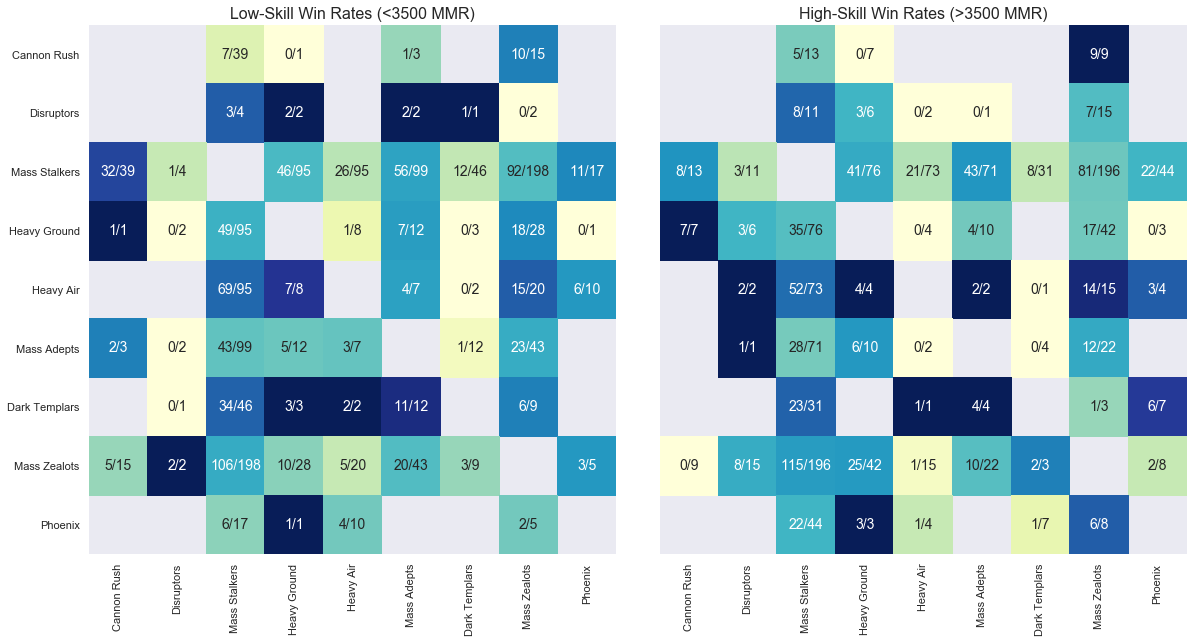

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plt.tight_layout()

mask = np.zeros_like(low_elo_plot_data)
# mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = True

sns.heatmap(low_elo_plot_data, cmap="YlGnBu", annot=low_elo_plot_labels, fmt='', ax=ax1, cbar=False, mask=mask, annot_kws={"size": 14})

ax1.set_title("Low-Skill Win Rates (<3500 MMR)", fontsize=16)
# ax1.set(xlabel='P2 Strategy', ylabel='P1 Strategy')

ax1.set_xticklabels(labels=strat_names, rotation=90)
ax1.set_yticklabels(labels=strat_names, rotation=0)

mask = np.zeros_like(high_elo_plot_data)
# mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = True

sns.heatmap(high_elo_plot_data, cmap="YlGnBu", annot=high_elo_plot_labels, fmt='', ax=ax2, cbar=False, mask=mask, annot_kws={"size": 14})

ax2.set_title("High-Skill Win Rates (>3500 MMR)", fontsize=16)
# ax2.set(xlabel='P2 Strategy', ylabel='P1 Strategy')

ax2.set_xticklabels(labels=strat_names, rotation=90)
ax2.set_yticklabels(labels=[], rotation=0)

plt.show()
fig.savefig("results.pdf", bbox_inches="tight")